## Importing required libraries

In [1]:
# suppressing warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import random
import math
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Iterable, List

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.functional as F

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k

from torchdata.datapipes.iter import IterableWrapper, Mapper

from nltk.translate.bleu_score import sentence_bleu

!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------ --------------------------------- 2.1/12.8 MB 11.8 MB/s eta 0:00:01
     ---------- ----------------------------- 3.4/12.8 MB 8.8 MB/s eta 0:00:02
     ---------------- ----------------------- 5.2/12.8 MB 8.6 MB/s eta 0:00:01
     ---------------------- ----------------- 7.3/12.8 MB 8.9 MB/s eta 0:00:01
     ------------------------------- -------- 10.0/12.8 MB 9.5 MB/s eta 0:00:01
     ------------------------------------- - 12.3/12.8 MB 10.0 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 9.9 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
     ----- ---------------------------------- 1.8/14.6 MB 10.1 MB/s eta 0:00:02
     ----------- ---------------------------- 4.2/14.6 MB 11.0 MB/s eta 0:00:01
     ------------------ ------------

#### Checking if CUDA is available

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


## The Encoder

In [4]:
# a rrn implemented using "nn.EmbeddingBag", "nn.LSTM", "nn.Dropout" functions from "pytorch" library
class Encoder(nn.Module):
    def __init__(self, vocab_len, emb_dim, hid_dim, n_layers, dropout_prob):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(vocab_len, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_batch):
        embed = self.dropout(self.embedding(input_batch))
        embed = embed.to(device)
        outputs, (hidden, cell) = self.lstm(embed)

        return hidden, cell

#### Encoder -> example of one forward pass

In [5]:
# dummy data
vocab_len = 8
emb_dim = 10
hid_dim = 8
n_layers = 1
dropout_prob = 0.5

# instantiating the model
encoder_t = Encoder(vocab_len, emb_dim, hid_dim, n_layers, dropout_prob).to(device)

In [6]:
# dummy data 
src_batch = torch.tensor([0,3,4,2,1]) #where 0,3,4,2,1 are vocab indecies
src_batch = src_batch.t().to(device)

# getting the embedding of the text token indices
embedded = encoder_t.embedding(src_batch)
# appling dropout to embedded
embedded_dropout = encoder_t.dropout(embedded)
embedded_dropout.to(device)
# passing through the lstm
outputs, (hidden_t, cell_t) = encoder_t.lstm(embedded_dropout)

print(f"Input(src) tensor  [shape -> {src_batch.shape[0]}]:-\n", src_batch)
print(f"\nEmbedded tokens  [shape -> {embedded.shape[0]}]:-\n", embedded)
print(f"\nAfter dropout:-  [shape -> {embedded_dropout.shape[0]}]\n", embedded_dropout)
print(f"\nHidden:-         [shape -> {hidden_t.shape[0]}]\n", hidden_t)
print(f"\nCell:-           [shape -> {cell_t.shape[0]}]\n", cell_t)
print(f"\nOutput:-         [shape -> {outputs.shape[0]}]\n", outputs)

Input(src) tensor  [shape -> 5]:-
 tensor([0, 3, 4, 2, 1], device='cuda:0')

Embedded tokens  [shape -> 5]:-
 tensor([[ 0.3585,  0.8377, -1.9292,  0.8428,  0.1710,  0.6395, -0.2197,  0.7238,
          1.2359,  0.1978],
        [ 0.7911, -1.0237, -0.9125,  0.2680, -0.1491, -0.4331, -0.7756, -0.1474,
          0.4680, -0.8852],
        [-0.5151, -0.1129, -1.2508,  0.1233,  0.2947,  1.5041,  0.5916, -2.1000,
         -0.2711, -1.0199],
        [-2.2576, -1.0254, -1.6649, -0.5063,  0.3664, -0.2478, -2.0347,  1.1515,
          0.5480,  0.0885],
        [ 0.6067,  0.9885, -0.8129, -1.0295,  1.7666, -1.5603, -0.3873,  2.1004,
         -0.5682,  0.4329]], device='cuda:0', grad_fn=<EmbeddingBackward0>)

After dropout:-  [shape -> 5]
 tensor([[ 0.0000,  1.6754, -0.0000,  1.6855,  0.0000,  0.0000, -0.0000,  1.4476,
          0.0000,  0.3956],
        [ 0.0000, -2.0473, -0.0000,  0.5360, -0.2982, -0.0000, -1.5511, -0.2949,
          0.0000, -0.0000],
        [-1.0302, -0.0000, -2.5016,  0.2465,  0

## The Decoder

In [7]:
# a rrn implemented using "nn.EmbeddingBag", "nn.Linear" ,"nn.LSTM", "nn.Dropout", "nn.LogSoftmax" functions from "pytorch" library
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input = [batch_size]
        input = input.unsqueeze(0) # input = [1, batch_size]
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction_logit = self.fc_out(output.squeeze(0))
        prediction = self.softmax(prediction_logit)

        return prediction, hidden, cell

#### Decoder -> example of one forward pass

In [8]:
# dummy data
output_dim = 6
emb_dim = 10
hid_dim = 8
n_layers = 1
dropout = 0.5

# instantiating the model
decoder_t = Decoder(output_dim, emb_dim, hid_dim, n_layers, dropout).to(device)

In [9]:
# dummy data 
input_t = torch.tensor([0]).to(device) # <bos>

# getting the embedding of the input text token <bos>
embedded = decoder_t.embedding(input_t)
# appling dropout to embedded
embedded_dropout = decoder_t.dropout(embedded)
embedded_dropout.to(device)
# passing through the lstm
output, (hidden, cell) = decoder_t.lstm(embedded_dropout, (hidden_t, cell_t))
# passing through the fully connected layer
prediction_logit = decoder_t.fc_out(output)
# appling softmax
prediction = decoder_t.softmax(prediction_logit)

print(f"Input(target) tensor  [shape -> {input_t.shape[0]}]:-\n", input_t)
print(f"\nEmbedded tokens  [shape -> {embedded.shape[0]}]:-\n", embedded)
print(f"\nAfter dropout:-  [shape -> {embedded_dropout.shape[0]}]\n", embedded_dropout)
#print(f"\nRNN Hidden:-     [shape -> {hidden.shape[0]}]\n", hidden)
#print(f"\nRNN Cell:-       [shape -> {cell.shape[0]}]\n", cell)
print(f"\nRNN Output:-     [shape -> {output.shape[0]}]\n", output)
print(f"\nFC layer Out:-   [shape -> {prediction_logit.shape[0]}]\n", prediction_logit)
print(f"\nSoftmax to Out:- [shape -> {prediction.shape[0]}]\n", prediction)

Input(target) tensor  [shape -> 1]:-
 tensor([0], device='cuda:0')

Embedded tokens  [shape -> 1]:-
 tensor([[ 0.4737, -0.4073, -0.2847, -0.3208, -1.1490,  0.9778,  0.4083, -0.1516,
         -0.5160,  0.1409]], device='cuda:0', grad_fn=<EmbeddingBackward0>)

After dropout:-  [shape -> 1]
 tensor([[ 0.9474, -0.0000, -0.5694, -0.6417, -0.0000,  1.9556,  0.8166, -0.0000,
         -0.0000,  0.0000]], device='cuda:0', grad_fn=<NativeDropoutBackward0>)

RNN Output:-     [shape -> 1]
 tensor([[-0.3914,  0.3574,  0.0556,  0.1918, -0.2278, -0.0491,  0.1560, -0.1141]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)

FC layer Out:-   [shape -> 1]
 tensor([[ 0.1705,  0.1983,  0.0593,  0.2768,  0.3496, -0.3505]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

Softmax to Out:- [shape -> 1]
 tensor([[-1.7622, -1.7344, -1.8734, -1.6559, -1.5831, -2.2832]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


#### Encoder-decoder connection

In [10]:
# dummy data 
src = torch.tensor([[0,3,4,2,1]]) #where 0,3,4,2,1 are vocab indecies
src = src.t().to(device)
# instantiating the encoder model
encoder_t = Encoder(vocab_len, emb_dim, hid_dim, n_layers, dropout_prob).to(device)
# geting the encoder output
hidden_t , cell_t = encoder_t(src)

print(f"Decoder Input:- [shape - {src.shape}]"," (src_length, batch_size)\n",src)
print("\nEncoder Context vectors:-")
print(f"\nHidden:- [shape - {hidden_t.shape}]"," (1, batch_size, hid_dim)\n",hidden_t)
print(f"\nCell:- [shape - {cell_t.shape}]"," (1, batch_size, hid_dim)\n", cell_t)



# dummy data 
trg = torch.tensor([[0],[2],[3],[5],[1]]).to(device) # 0 -> <bos>
# instantiating the decoder model
decoder_t = Decoder(output_dim, emb_dim, hid_dim, n_layers, dropout).to(device)

# a tensor to store decoder opuputs at each time step
batch_size = trg.shape[1]
trg_len = trg.shape[0]
trg_vocab_size = decoder_t.output_dim
outputs_t = torch.zeros(trg_len, batch_size, trg_vocab_size).to(device)

# the first input to the decoder is the <bos> token
input = trg[0,:]

print("\n----------------------------------------------------------------------------------------------------------------------------------------------")
print(f"\nTarget String:- [shape - {trg.shape}]"," (trg_length, batch_size)\n",trg)
print(f"\nFirst Decoder Input - <bos> [shape - {input.shape}]"," (batch_size)\n",input, "\n")

# looping through the trg length
for t in range(1, trg_len):
    output_t, hidden_t, cell_t = decoder_t(input, hidden_t, cell_t)
    # storing the output in current time step
    outputs_t[t] = output_t
    #getting the predicted token  index
    top_1 = output_t.argmax(1)
    # deciding weather to use tracher forcing
    teacher_force = random.random() < 0.5 # 0.5 -> teacher forcing ratio
    input = trg[t] if teacher_force else top_1

print(f"Decoder output in each time step [shape -> {outputs_t.shape}]"," (trg_length, batch_size, trg_vocab_size)\n",outputs_t)

Decoder Input:- [shape - torch.Size([5, 1])]  (src_length, batch_size)
 tensor([[0],
        [3],
        [4],
        [2],
        [1]], device='cuda:0')

Encoder Context vectors:-

Hidden:- [shape - torch.Size([1, 1, 8])]  (1, batch_size, hid_dim)
 tensor([[[ 0.0709,  0.2561, -0.1058,  0.2744,  0.2647,  0.1462, -0.0461,
          -0.1029]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>)

Cell:- [shape - torch.Size([1, 1, 8])]  (1, batch_size, hid_dim)
 tensor([[[ 0.1231,  0.4201, -0.1828,  0.6003,  0.4824,  0.2155, -0.1338,
          -0.1597]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>)

----------------------------------------------------------------------------------------------------------------------------------------------

Target String:- [shape - torch.Size([5, 1])]  (trg_length, batch_size)
 tensor([[0],
        [2],
        [3],
        [5],
        [1]], device='cuda:0')

First Decoder Input - <bos> [shape - torch.Size([1])]  (batch_size)
 tensor([0], device='cuda:0') 


In [11]:
# making predictions
pred_tokens = outputs_t.argmax(2)
print(pred_tokens)

tensor([[0],
        [4],
        [1],
        [4],
        [4]], device='cuda:0')


## Sequence-to-sequence model

In [12]:
# connecting encoder and decoder components to create the seq2seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, trg_vocab):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.trg_vocab = trg_vocab

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimension of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(device)

        #last encoder hidden state
        hidden, cell = self.encoder(src)
        hidden.to(device)
        cell.to(device)

        #first input to decoder is <bos>
        input = trg[0,:]

        for t in range(1, trg_len):
            output , hidden, cell = self.decoder(input, hidden, cell)
             # storing the output from the current time step
            outputs[t] = output
            #getting the predicted token index
            top_1 = output.argmax(1)
            # deciding weather to use tracher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[t] if  teacher_force else top_1
        
        return outputs

#### Example loss of one example document

In [13]:
print(f"Decoder output in each time step [shape -> {outputs_t.shape}]"," (trg_length, batch_size, trg_vocab_size)\n",outputs_t)
output_t1 = outputs_t.clone().detach()
output_t1 = output_t1[1:].view(-1,output_dim)
print(f"\nRemoving the 1st row <bos> and re-shaping the output [shape - {output_t1.shape}]"," ([(trg_length-1) * batch_size], trg_vocab_size)\n",output_t1)
print("\n-------------------------------------------------------------------------------------------------------------------------------------------\n")
print(f"\nTarget String:- [shape - {trg.shape}]"," (trg_length, batch_size)\n",trg)
trg1 = trg.clone().detach()
trg1 = trg1[1:].contiguous().view(-1)
print(f"\nRemoving the 1st row <bos> and re-shaping the target [shape - {trg1.shape}]"," [(trg_length-1) * batch_size]\n",trg1)
print("\n-------------------------------------------------------------------------------------------------------------------------------------------\n")
print(f"Cross Entropy Loss:- ", nn.CrossEntropyLoss()(output_t1,trg1))

Decoder output in each time step [shape -> torch.Size([5, 1, 6])]  (trg_length, batch_size, trg_vocab_size)
 tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[-1.7682, -1.8405, -1.8126, -2.0329, -1.5835, -1.7650]],

        [[-1.7730, -1.7178, -1.7575, -1.8974, -1.7614, -1.8547]],

        [[-1.7327, -1.8727, -1.8761, -1.9896, -1.5727, -1.7599]],

        [[-1.8133, -1.8763, -1.7613, -2.0904, -1.5659, -1.7182]]],
       device='cuda:0', grad_fn=<CopySlices>)

Removing the 1st row <bos> and re-shaping the output [shape - torch.Size([4, 6])]  ([(trg_length-1) * batch_size], trg_vocab_size)
 tensor([[-1.7682, -1.8405, -1.8126, -2.0329, -1.5835, -1.7650],
        [-1.7730, -1.7178, -1.7575, -1.8974, -1.7614, -1.8547],
        [-1.7327, -1.8727, -1.8761, -1.9896, -1.5727, -1.7599],
        [-1.8133, -1.8763, -1.7613, -2.0904, -1.5659, -1.7182]],
       device='cuda:0')

-----------------------------------------------------------------------------------------------

#### A function to train the model

In [14]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    train_iterator = tqdm(iterator, desc="Training", leave=False)

    for i, (src, trg) in enumerate(train_iterator):
        # senting the src anf trg tensors to device
        src = src.to(device)
        trg = trg.to(device)

        # clearing the gradinet from previous batch
        optimizer.zero_grad()

        # the models predictions - token probabilities
        output = model(src, trg)

        #----- trg shape -> [trg len, batch_size]
        #----- output shape -> [trg_len, batch_size, output_dim]

        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim) # removing <bos> and re-shaping
        trg = trg[1:].contiguous().view(-1) # removing <bos> and re-shaping

        #----- trg shape -> [(trg len -1) * batch_size]
        #----- output shape -> [(trg len -1) * batch_size, output dim]

        # computing the loss
        loss = criterion(output, trg)
        # compiting the gradient
        loss.backward()
        # cliping the gradien
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        # updating the weights
        optimizer.step()

        # Updating the tqdm
        train_iterator.set_postfix(loss=loss.item())

        epoch_loss += loss.item()

    return epoch_loss / len(list(iterator))

#### A function to evaluat the model

In [15]:
def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = 0
    valid_iterator = tqdm(iterator, desc="Training", leave=False)

    with torch.no_grad():

        for i, (src, trg) in enumerate(valid_iterator):
            src = src.to(device)
            trg = trg.to(device)

            output = model(src,trg,0) # 0 -> turning off teacher forcing
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim) # removing <bos> and re-shaping
            trg = trg[1:].contiguous().view(-1) # removing <bos> and re-shaping

            loss = criterion(output, trg)
            valid_iterator.set_postfix(loss=loss.item())
            epoch_loss += loss.item()
        return epoch_loss/len(list(iterator))

## Data pre-processing

In [16]:
# running the code that has been created that contains all the transformation processes on data.
%run Multi30K_de_en_dataloader.py

In [17]:
# geting the train and valid data-loaders
train_dataloader, valid_dataloader = get_translation_dataloaders(batch_size = 4)

print("The first batch in train_dataloader:- ")
src, trg = next(iter(train_dataloader))
print("\nSRC tensor:-\n", src)
print("\nTRG tensor:-\n", trg)

The first batch in train_dataloader:- 

SRC tensor:-
 tensor([[    2,     2,     2,     2],
        [    3,  5510,  5510, 12642],
        [    1,     3,     3,     8],
        [    1,     1,     1,  1701],
        [    1,     1,     1,     3]], device='cuda:0')

TRG tensor:-
 tensor([[   2,    2,    2,    2],
        [   3, 6650,  216,    6],
        [   1, 4623,  110, 3398],
        [   1,  259, 3913,  202],
        [   1,  172, 1650,  109],
        [   1, 9953, 3823,   37],
        [   1,  115,   71,    3],
        [   1,  692, 2808,    1],
        [   1, 3428, 2187,    1],
        [   1,    5,    5,    1],
        [   1,    3,    3,    1]], device='cuda:0')


In [18]:
# printing the data from an example batch
data_itr = iter(train_dataloader)
for n in range(1000):
    german, english = next(data_itr)

print("The 1000th batch in train_dataloader:- ")
print("\nGerman tensor:-\n", german)
print("\nEnglish tensor:-\n", english)

german = german.T
english = english.T

print("\nGerman T tensor:-\n", german)
print("\nEnglish T tensor:-\n", english)

# printing the actual text
print("\nGerman Text:-\n") # The german text is in reverse
for e in german:
    print(index_to_eng(e))

print("\nEnglish Text:-\n")
for e in english:
    print(index_to_eng(e))


The 1000th batch in train_dataloader:- 

German tensor:-
 tensor([[   2,    2,    2,    2],
        [  21,   84,    5,   14],
        [ 773,   42,  315,   17],
        [8314,  561,  149,  332],
        [  10,   25,   22,   63],
        [ 541,  458, 1121,    6],
        [3125,   22,  104, 4505],
        [ 174,   94,  901,  468],
        [   4,    4,    4,    4],
        [   3,    3,    3,    3]], device='cuda:0')

English tensor:-
 tensor([[   2,    2,    2,    2],
        [  19,   83, 2989,    6],
        [  52,   17,   10,   16],
        [ 266,  363,   56,  616],
        [   7,  354,   18,    4],
        [ 287,   20,   27,  477],
        [1198, 1528,  515,   29],
        [ 134,    5,   60,  175],
        [  67,    3,  210,   28],
        [   4,    1, 2688,  256],
        [2266,    1,   63,  552],
        [   5,    1,  811,    5],
        [   3,    1,    5,    3],
        [   1,    1,    3,    1]], device='cuda:0')

German T tensor:-
 tensor([[   2,   21,  773, 8314,   10,  541, 3125, 

In [19]:
english

tensor([[   2,   19,   52,  266,    7,  287, 1198,  134,   67,    4, 2266,    5,
            3,    1],
        [   2,   83,   17,  363,  354,   20, 1528,    5,    3,    1,    1,    1,
            1,    1],
        [   2, 2989,   10,   56,   18,   27,  515,   60,  210, 2688,   63,  811,
            5,    3],
        [   2,    6,   16,  616,    4,  477,   29,  175,   28,  256,  552,    5,
            3,    1]], device='cuda:0')

## Training the model

#### Initializations

In [20]:
SEED = 1234 # for result reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [21]:
INPUT_DIM = len(vocab_transform['de'])
OUTPUT_DIM = len(vocab_transform['en'])
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 1
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, trg_vocab=vocab_transform['en']).to(device)

In [22]:
# initializing the initial weights
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(19214, 128)
    (lstm): LSTM(128, 256, dropout=0.3)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10837, 128)
    (lstm): LSTM(128, 256, dropout=0.3)
    (fc_out): Linear(in_features=256, out_features=10837, bias=True)
    (softmax): LogSoftmax(dim=1)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (trg_vocab): Vocab()
)

In [23]:
# no.of trainable paraments 
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model)}:, trainable parameters")

The model has 7422165:, trainable parameters


In [24]:
# defining the loss criterion, optimizer using functions from the PyTorch Library 
optimizer = optim.Adam(model.parameters())
PAD_IDX = vocab_transform['en'].get_stoi()['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [25]:
# a helper function for claculating time taken for training
def epoch_time(start_time, end_time):
    elasped_time = end_time - start_time
    elasped_mins = int(elasped_time/60)
    elasped_secs = int(elasped_time - (elasped_mins * 60))
    return elasped_mins, elasped_secs

In [26]:
# training the model
torch.cuda.empty_cache()

N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')
best_train_loss = float('inf')
train_losses = []
valid_losses = []

train_PPLs = []
valid_PPLs = []

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    train_ppl = math.exp(train_loss)
    valid_loss = evaluate(model, valid_dataloader, criterion)
    valid_ppl = math.exp(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "RNN-TR-model.pt")

    train_losses.append(train_loss)
    train_PPLs.append(train_ppl)
    valid_losses.append(valid_loss)
    valid_PPLs.append(valid_ppl)

    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}")
    print(f"\t Val. Loss: {valid_loss:.3f} | Train PPL: {valid_ppl:7.3f}")

Epoch: 01 | Time: 3m 52s
	Train Loss: 4.384 | Train PPL:  80.174
	 Val. Loss: 5.185 | Train PPL: 178.531


Epoch: 02 | Time: 4m 35s
	Train Loss: 3.673 | Train PPL:  39.356
	 Val. Loss: 4.781 | Train PPL: 119.235


Epoch: 03 | Time: 4m 17s
	Train Loss: 3.268 | Train PPL:  26.271
	 Val. Loss: 4.428 | Train PPL:  83.760


Epoch: 04 | Time: 6m 40s
	Train Loss: 2.965 | Train PPL:  19.396
	 Val. Loss: 4.274 | Train PPL:  71.826


Epoch: 05 | Time: 3m 32s
	Train Loss: 2.729 | Train PPL:  15.325
	 Val. Loss: 4.145 | Train PPL:  63.107


In [27]:
# loading the trained model
#model.load_state_dict(torch.load('RNN-TR-model.pt',map_location=torch.device('cpu')))

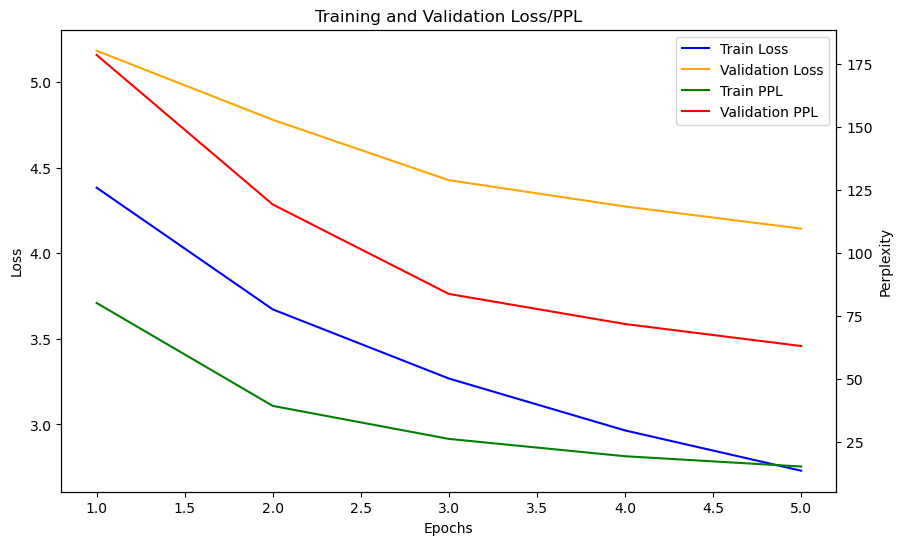

In [28]:
#### Visualizing the training and validation loss

# Create a list of epoch numbers
epochs = [epoch+1 for epoch in range(N_EPOCHS)]

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plotting the training and validation loss
ax1.plot(epochs, train_losses, label='Train Loss', color='blue')
ax1.plot(epochs, valid_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss/PPL')

# Plotting the training and validation perplexity
ax2.plot(epochs, train_PPLs, label='Train PPL', color='green')
ax2.plot(epochs, valid_PPLs, label='Validation PPL', color='red')
ax2.set_ylabel('Perplexity')

# Adjust the y-axis scaling for PPL plot
ax2.set_ylim(bottom=min(min(train_PPLs), min(valid_PPLs)) - 10, top=max(max(train_PPLs), max(valid_PPLs)) + 10)

# Set the legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right')


# Show the plot
plt.show()

## Model Inference

In [78]:
# Actual translation: Asian man sweeping the walkway.
src_sentence = 'Ein asiatischer Mann kehrt den Gehweg.'
print("The src sentence:- ",src_sentence)

#getting the token tensors of the src text
src_tensor = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1).to(device)
print("\nThe src token indexes tensor:-\n",src_tensor)

#passing the src through the encoder
hidden, cell = model.encoder(src_tensor)
print("\nEncoder - hidden dimention :- ", hidden.shape, "-> (1, batch_size, hid_dim)")
print("Encoder - cell dimention   :- ", cell.shape, "-> (1, batch_size, hid_dim)")

print("\n---------------------------------------------------------------------------------------------------------------------------------------\n")

# trg sentence starts with a <bos> tag
trg_vocab=vocab_transform['en']
trg_indexes = [trg_vocab.get_stoi()['<bos>']]
print("Indexs of generated text so far:- ", trg_indexes)
trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(1).to(device) #adding batch dimention
print("A tensor to store the generated text:- \n",trg_tensor, "| Dimention:- ", trg_tensor.shape, "-> (batch_size, seq_len)")

#getting the next word prediction
output, hidden, cell = model.decoder(trg_tensor[-1], hidden, cell)
print("\nDecoder - output dimention :- ", output.shape, "-> (batch_size, trg_vacab_len)")
print("Decoder - hidden dimention :- ", hidden.shape, "-> (1, batch_size, hid_dim)")
print("Decoder - cell dimention   :- ", cell.shape, "-> (1, batch_size, hid_dim)")

#next word
pred_token = output.argmax(1)[-1].item()
print("\nPredected token index:- ",pred_token)
# appending to the trg_tensor (generated sentences)
trg_indexes.append(pred_token)
print("Indexs of generated text so far:- ", trg_indexes)

The src sentence:-  Ein asiatischer Mann kehrt den Gehweg.

The src token indexes tensor:-
 tensor([[   2],
        [   5],
        [ 402],
        [  12],
        [1100],
        [  34],
        [ 145],
        [   4],
        [   3]], device='cuda:0')

Encoder - hidden dimention :-  torch.Size([1, 1, 256]) -> (1, batch_size, hid_dim)
Encoder - cell dimention   :-  torch.Size([1, 1, 256]) -> (1, batch_size, hid_dim)

---------------------------------------------------------------------------------------------------------------------------------------

Indexs of generated text so far:-  [2]
A tensor to store the generated text:- 
 tensor([[2]], device='cuda:0') | Dimention:-  torch.Size([1, 1]) -> (batch_size, seq_len)

Decoder - output dimention :-  torch.Size([1, 10837]) -> (batch_size, trg_vacab_len)
Decoder - hidden dimention :-  torch.Size([1, 1, 256]) -> (1, batch_size, hid_dim)
Decoder - cell dimention   :-  torch.Size([1, 1, 256]) -> (1, batch_size, hid_dim)

Predected token in

In [82]:
# a generator function to generate tralnslation text.
def generate_translation(model, src_sentence, src_vocab, trg_vocab, max_len=50):
    model.eval()
    with torch.no_grad():
        #geting the token tensor of the src text
        src_tensor = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1).to(device)

        # passinf the source tensor through the encoder
        hidden, cell = model.encoder(src_tensor)

        # Creating a tensor to store the generated translation indexes
        trg_indexes = [trg_vocab.get_stoi()['<bos>']] # sentence starts with <bos> 
        
        #converting the token indexes to a tensor
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(1).to(device) #adding batch dimention

        # generating the translations
        for _ in range(max_len):
            output, hidden, cell = model.decoder(trg_tensor[-1], hidden, cell) #passing the previous output as input
            pred_token = output.argmax(1)[-1].item()
            # adding to generated trnsalation tensor
            trg_indexes.append(pred_token)

            #checking if the prediction was <eos> token
            if pred_token == trg_vocab.get_stoi()['<eos>']:
                break

            #converting the token indexes to a tensor
            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(1).to(device) #adding batch dimention

    # converting teh generated indexex to text
    trg_tokens = [trg_vocab.get_itos()[i] for i in trg_indexes]

    # removing <bos> and <eos>
    if trg_tokens[0] == '<bos>':
        trg_tokens = trg_tokens[1:]
    if trg_tokens[-1] == '<eos>':
        trg_tokens = trg_tokens[:-1]

    return ' '.join(trg_tokens)    

generated_translation = generate_translation(model, src_sentence=src_sentence, src_vocab=vocab_transform['de'], trg_vocab=vocab_transform['en'], max_len=12)
print(generated_translation)

An Asian man is on the sidewalk sidewalk .


## BLUE score

In [92]:
#a function to calculate the blue score

def calculate_bleu_score(generated_translation, reference_translations):
    reference = [reference.split() for reference in reference_translations]
    hypothesis = generated_translation.split()

    # calculate the BLUE score
    blue_score = sentence_bleu(reference, hypothesis)
    return blue_score

In [93]:
reference_translations = [
    "Asian man sweeping the walkway .",
    "An asian man sweeping the walkway .",
    "An Asian man sweeps the sidewalk .",
    "An Asian man is sweeping the sidewalk .",
    "An asian man is sweeping the walkway .",
    "Asian man sweeping the sidewalk ."
]

bleu_score = calculate_bleu_score(generated_translation, reference_translations)
print("BLEU Score:", bleu_score)

BLEU Score: 0.39005788655345264
